In [19]:
# Importing PlaidML. Make sure you follow this order
#import plaidml.keras
#plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [90]:
import numpy as np
import pandas as pd 
import cv2
from fastai.vision import *
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import shutil
from glob import glob
%matplotlib inline
import networkx as nx

import networkx as nx
import nxviz
import community
import itertools
import operator

import sys
from PIL import Image

import sys
import os
import numpy as np
from matplotlib import pyplot as plt

from keras import datasets
import keras

import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Loading dataset

In [21]:
def open_images (directory):
    
    images_all = []
    images = glob(directory)
    i_ = 0
    for img in images:
        im = cv2.imread(img)
        images_all.append(im)
        i_ += 1
        
    return images_all

In [22]:
holi = open_images ("data/resized/resized/**")

In [25]:
arts = np.asarray(holi)

In [96]:
size = 500

In [97]:
artist_path = glob("data/resized/resized/**")

artists = []
for artist in artist_path[:size]:
    art = (",").join(re.findall("\w+_", artist))[:-1]
    artists.append(art)

In [98]:
le = LabelEncoder()

# y lo aplicamos al listado de columnas que se definieron antes
y = le.fit_transform(artists)

In [99]:
y

array([18, 46,  2, 10, ...,  0, 32, 10, 46])

In [100]:
X = arts[:size]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess data

In [102]:
# preprocess data

def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = keras.utils.to_categorical(y)
    
    return x, y

In [103]:
class_names = ['aeroplane', 'car', 'bird']

x_train, y_train = get_three_classes (x_train, y_train)
x_test, y_test = get_three_classes (x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

ValueError: not enough values to unpack (expected 2, got 1)

# Visualization helper function

In [18]:
def show_random_examples (x, y, p):
    indices = np.random.choice (range(x.shape[0]), 10, replace = False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure (figsize = (10, 5))
    for i in range (10):
        plt.subplot (2, 5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show

# Visualize examples

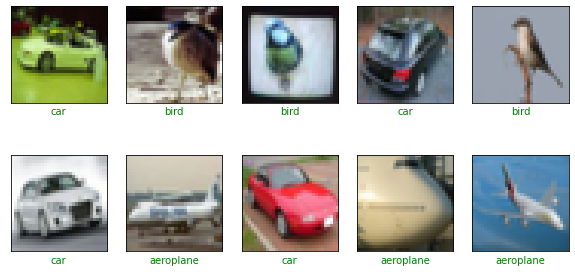

In [19]:
show_random_examples(x_train, y_train, y_train)

# Creating our CNN models

In [20]:
from keras.layers import Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Input, Dense
from keras.models import Sequential, Model


In [21]:
def simple_cnn(classes, input_shape):
    """
    * 7x7 layer conv with 32 filters, stride is (2,2)
    * ReLU
    * Dense Layer
    * SVM
    """
    model = Sequential()
    model.add(Conv2D(filters=32,
                            kernel_size=7,
                            # kernel_regularizer=keras.regularizers.l2,
                            strides=2,
                            input_shape=input_shape,
                            ))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(classes))
    model.add(Activation('linear'))
    return model




In [22]:
def complex_cnn(classes, input_shape):
    """
    * 7x7 layer Conv layer with 32 filters
    * BN Layer
    * ReLu Activation Layer
    * 2x2 Max Polling Layer
    * Dense Layer with 1024 output units.
    * BN Layer
    * ReLU
    * Dense Layer with 10 outputs.
    """
    complex_model = Sequential()
    complex_model.add(Conv2D(filters=32,
                             kernel_size=7,
                             padding='same',
                             input_shape=input_shape,
                             ))
    complex_model.add(BatchNormalization())
    complex_model.add(Activation('relu'))
    complex_model.add(MaxPool2D(padding='same'))
    complex_model.add(Flatten())
    complex_model.add(Dense(1024))
    complex_model.add(BatchNormalization())
    complex_model.add(Activation('relu'))
    complex_model.add(Dense(classes))
    complex_model.add(Activation('softmax'))
    return complex_model

In [23]:
def cnn_model(classes, input_shape):
    def add_conv_block(model, num_filters, input_shape=None):
        if input_shape:
            model.add(Conv2D(num_filters, 3, activation='relu', padding='same', input_shape=input_shape))
        else:
            model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = Sequential()
    
    model = add_conv_block(model, 32, input_shape=input_shape)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(classes, activation='softmax'))
    
    return model



In [24]:
# model = cnn_model(3, x_train.shape[1:])
model = cnn_model(3, x_train.shape[1:])


# Explore the model

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 64)       

In [26]:
from keras.utils import plot_model
plot_model(model)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

# Compile the model

In [16]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', metrics=['accuracy']
    )

# Train the model

In [18]:
# train the model

h = model.fit(
    x_train / 255., y_train,
    validation_data = (x_test / 255., y_test),
    epochs = 10, batch_size = 128,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 232s 15ms/step - loss: 0.8665 - accuracy: 0.6823 - val_loss: 3.1930 - val_accuracy: 0.3333


OSError: Unable to create file (unable to open file: name = 'models/model_0.333.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

# Evaluate the model

In [17]:
# final predictions

accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

NameError: name 'h' is not defined

In [66]:
preds = model.predict(x_test / 255.)

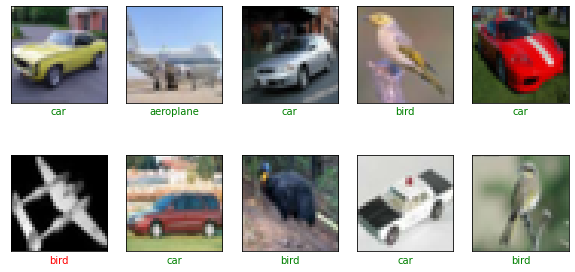

In [67]:
show_random_examples(x_test, y_test, preds)

# Export the model

In [68]:
model.save('models/cifar_10.h5')

In [69]:
from keras.models import load_model
model = load_model('models/cifar_10.h5')